In [270]:
import numpy as np
import pandas as pd

import pymysql
import dotenv
import os
import pickle
import seaborn as sns
import matplotlib

from datetime import timedelta

import matplotlib.pyplot as plt

# Normalization/Standardization
from sklearn.preprocessing import MinMaxScaler, StandardScaler, OneHotEncoder

from sklearn.linear_model import LinearRegression, SGDRegressor, Ridge, Lasso
from sklearn.model_selection import train_test_split

import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, Dropout, Conv1D, GRU
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau, ModelCheckpoint
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.losses import Huber
from tensorflow.keras.optimizers import Adam

from tensorflow.keras.saving import save_model

# 경고 무시 코드 추가
import warnings
warnings.filterwarnings('ignore')

def pltconfig_default() :
  sns.reset_defaults()
  %matplotlib inline

pltconfig_default()

matplotlib.rcParams

matplotlib.rcParams['font.family']

current_font_list = matplotlib.rcParams['font.family']

font_path = 'C:\\Windows\\Fonts\\batang.ttc'

kfont = matplotlib.font_manager.FontProperties(fname=font_path).get_name()

matplotlib.rcParams['font.family'] = [kfont] + current_font_list


In [233]:
# with open('StandardScalar_final_data', 'rb') as file :
#   St_NotEncode_data = pickle.load(file)

St_NotEncode_data = pd.read_pickle("StandardScalar_final_data")
  
print(St_NotEncode_data.shape)

(17422, 9)


In [234]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Data")
SNE_X, SNE_y = Feature_Label(St_NotEncode_data)
print(SNE_X.shape, SNE_y.shape)
SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10, shuffle=False)
print(SNE_X_train.shape, SNE_X_test.shape, SNE_y_train.shape, SNE_y_test.shape)
print("=======================================")

StandardScaler Not Encode Data
(17422, 8) (17422,)
(13937, 8) (3485, 8) (13937,) (3485,)


<Axes: ylabel='8'>

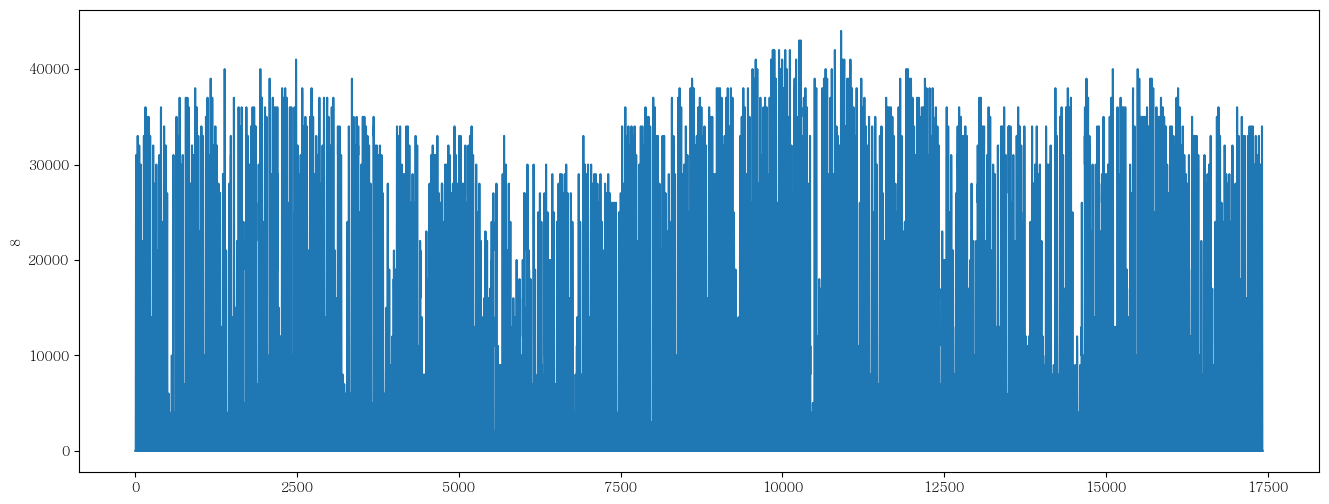

In [235]:
# fig, axe = plt.subplots(figsize=(16, 6), layout='constrained')
plt.figure(figsize=(16, 6))

sns.lineplot(y=SNE_y, x=SNE_X.index)

In [236]:
# SNE_X_train, SNE_X_test, SNE_y_train, SNE_y_test = train_test_split(SNE_X, SNE_y, test_size=0.2, random_state=10, shuffle=False)

# print(SNE_X_train.shape, SNE_y_train.shape)

In [237]:
#일변량 시계열 (발전량만을 활용한 시계열 데이터셋)

def windowed_dataset(series, window_size, batch_size, shuffle) :
  series = tf.expand_dims(series, axis=-1)
  ds = tf.data.Dataset.from_tensor_slices(series)
  # window_size : 몇 개의 데이터로 다음 데이터를 예측할지 설정, stride : 윈도우 데이터셋을 몇 칸씩 이동할지 결정, drop_remainder : 뒤에 잔여 데이터 미처리 적용(데이터셋 사이즈가 달라지는 것을 방지)
  ds = ds.window(window_size + 1, stride=1, shift=1, drop_remainder=True) # window_size + 1 : X(feature)와 y(target) 값을 포함하는 범위(즉 +1은 y(target) 포함을 의미)
  # flat_map : map 함수와 동일하게 맵핑을 해주지만 flat한 결과값을 준다!(즉, 차원 -1)
  ds = ds.flat_map(lambda w: w.batch(window_size + 1))
  if shuffle :
    ds = ds.shuffle(1000)
  ds = ds.map(lambda w : (w[:-1], w[-1])) # w[:-1] : 학습 데이터 , w[-1] : 예측 데이터
  # batch : 배치를 구성해주는 함수 / prefetch : 미리 데이터를 fetch하는 개수 (병렬 처리하므로 학습 속도 개선 효과)
  return ds.batch(batch_size).prefetch(1)

In [238]:
WINDOW_SIZE=3
BATCH_SIZE=32 # 한번에 여러 개의 데이터를 처리하는 병렬 처리 형태로 계산 효율을 높일 수 있다. 즉, 성능, 메모리 측면에서 유리 + 또한 가중치 업데이트 횟수를 제어할 수 있음

In [239]:
# train_data = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, True) # 기존 적용
train_data = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(SNE_y_test, WINDOW_SIZE, BATCH_SIZE, False)
train_data_ns = windowed_dataset(SNE_y_train, WINDOW_SIZE, BATCH_SIZE, False)

In [240]:
for data in train_data.take(1) :  # take : 1개의 배치만 가져오기
  print(f'{data[0].shape}')
  print(f'{data[1].shape}')

(32, 3, 1)
(32, 1)


In [241]:
# test_model = Sequential([
#   Conv1D(filters=32, kernel_size=30,
#          padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
#          activation='relu',
#          input_shape=[WINDOW_SIZE, 1]),
#   LSTM(256, recurrent_dropout=0.5, activation='tanh', return_sequences=True),  
#   # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
#   # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
#   LSTM(128, activation='tanh', return_sequences=True),
#   LSTM(64, activation='tanh', return_sequences=True),
#   LSTM(32, activation='tanh'),
#   Dense(8, activation='relu'),
#   # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
#   Dense(1)
# ])

In [242]:
# 현재까지 loss가 가장 낮은 모델

lstm_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  LSTM(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  LSTM(64, activation='tanh', return_sequences=True),
  LSTM(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [243]:
rnn_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  SimpleRNN(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  SimpleRNN(64, activation='tanh', return_sequences=True),
  SimpleRNN(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [244]:
gru_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', # 시계열 데이터와 같은 순차 데이터를 다룰 때 유용한 방법으로 입력 데이터 주변에 가상의 값을 추가하여 출력 크기를 조정하거나 경계 효과를 제어하는데 사용된다
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  GRU(128, activation='tanh', return_sequences=True),  
  # tanh함수는 출력 범위가 -1~1로 제한되며 양수와 음수를 모두 다룰 수 있음
  # ReLU함수는 출력 범위가 0~1로 제한되며 음수의 경우 0으로 출력하여 음수값을 제거하는 효과가 있음, But, 음수를 처리하지 못해 그래디언트 소실 문제가 발생할 수 있음
  GRU(64, activation='tanh', return_sequences=True),
  GRU(32, activation='tanh'),
  Dense(8, activation='relu'),
  # Dropout(0.5), # 과적합을 방지하기 위해 사용되는 정규화 기법 중 하나로 학습 과정에서 일부 뉴런의 출력을 랜덤하게 0으로 만들어 모델의 일반화 능력을 향상시킨다
  Dense(1)
])

In [245]:
loss = Huber() # MSE(Mean Squared Error)와 MAE(Mean Absolute Error)의 특성을 혼합한 것으로 이상치에 민감하지 않으면서도 큰 오차에 덜 민감한 특성을 가진다
optimizer = Adam(learning_rate=0.001) # 0.0005
lstm_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
rnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
gru_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
# test_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])

In [246]:
# ReduceLROnPlateau : 학습 도중 learning_rate를 동적으로 조정하는 데 사용된다 (에코크 동안 지정된 지표(monitor)에 대한 개선이 없는 경우 learning_rate를 감소시킨다)
# 주요 파라미터 : monitor - 모니터링할 지표(검증 손실(val_loss), val_rmse, val_mae 등), factor - 학습률을 감소시킬 비율, patience : 지정된 에포크 동안 개선이 없을 경우 학습률 감소, mode - 판단 방식('auto', #                          'min', 'max'), min_lr - learning_rate 하한값 지정
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)

# EarlyStopping : 모델의 성능이 개선되지 않을 경우 학습을 조기 종료하여 불필요한 계산을 줄이고 과적합을 방지
# 주요 파라미터 : monitor - 모니터링할 지표, patience - 지정된 에포크 동안 개선이 없을 경우 종료, mode - 모니터링 지표의 개선 여부 판단 방식, verbose - EarlyStopping 동작 상황 출력 여부 지정
#                restore_best_weights - 적용 후 최적의 모델 가중치를 복원할지 여부를 지정                  
es = EarlyStopping(monitor='val_loss', patience=20)

# ModelCheckpoint : 학습 도중 지정된 지표(monitor) 기반하여 가장 성능이 좋은 모델 가중치를 저장 (지표가 개선되었을 때만 가중치 저장)
#                   filepath : 모델 가중치 저장 경로 지정 (`{epoch:02d}`와 같은 형식을 사용해 에포크 번호 등을 동적으로 포맷팅 가능), save_best_only - True 설정 시 가장 좋은 성능을 보인 모델 가중치만 저장

# mc = ModelCheckpoint('test_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm = ModelCheckpoint('new_stne_lstm_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm_ns = ModelCheckpoint('new_stne_lstm_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn = ModelCheckpoint('new_stne_rnn_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn_ns = ModelCheckpoint('new_stne_rnn_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru = ModelCheckpoint('new_stne_gru_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru_ns = ModelCheckpoint('new_stne_gru_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

# callback = [reduce_lr, es, mc]

In [247]:
# test_history = test_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=callback)

In [248]:
# loss : 모델이 훈련데이터에 대해 얼마나 잘 학습하고 있는지 평가하는 지표 (모델이 훈련데이터에 미치는 오차의 평균을 나타낸다)
# val_loss : 검증 데이터(validation data)에 대한 손실 값으로 검증 데이터를 사용해 모델의 일반화 성능을 평가한다 (즉, 훈련 데이터 외의 데이터에 대해서도 얼마나 잘 예측하는지를 판단)
# loss와 val_loss가 크지 않은 모델이 overfitting 되지 않고 이상적인 모델이다!

lstm_history = lstm_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm])
lstm_history_ns = lstm_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm_ns])

Epoch 1/500


    436/Unknown - 10s 7ms/step - loss: 7620.8555 - mse: 183686128.0000 - mae: 7621.2158
Epoch 1: val_loss improved from inf to 7108.02148, saving model to new_stne_lstm_weight.h5
436/436 [==============================] - 12s 10ms/step - loss: 7620.8555 - mse: 183686128.0000 - mae: 7621.2158 - val_loss: 7108.0215 - val_mse: 171552256.0000 - val_mae: 7108.4321 - lr: 0.0010
Epoch 2/500
431/436 [============================>.] - ETA: 0s - loss: 7573.4360 - mse: 182107744.0000 - mae: 7573.7803
Epoch 2: val_loss improved from 7108.02148 to 7054.41992, saving model to new_stne_lstm_weight.h5
436/436 [==============================] - 3s 8ms/step - loss: 7580.5415 - mse: 182240784.0000 - mae: 7580.8857 - val_loss: 7054.4199 - val_mse: 169658336.0000 - val_mae: 7054.7202 - lr: 0.0010
Epoch 3/500
436/436 [==============================] - ETA: 0s - loss: 7508.5376 - mse: 179655168.0000 - mae: 7508.8398
Epoch 3: val_loss improved from 7054.41992 to 6980.90820, saving model to new_stne_lstm_weigh

In [249]:
rnn_history = rnn_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn])
rnn_history_ns = rnn_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn_ns])

Epoch 1/500


    428/Unknown - 3s 2ms/step - loss: 7617.5039 - mse: 183790560.0000 - mae: 7617.8311
Epoch 1: val_loss improved from inf to 7079.02686, saving model to new_stne_rnn_weight.h5
436/436 [==============================] - 4s 4ms/step - loss: 7609.1899 - mse: 183270432.0000 - mae: 7609.5181 - val_loss: 7079.0269 - val_mse: 170534576.0000 - val_mae: 7079.3257 - lr: 0.0010
Epoch 2/500
427/436 [============================>.] - ETA: 0s - loss: 7517.6055 - mse: 180120112.0000 - mae: 7517.9087
Epoch 2: val_loss improved from 7079.02686 to 6955.62402, saving model to new_stne_rnn_weight.h5
436/436 [==============================] - 1s 3ms/step - loss: 7515.5371 - mse: 179894016.0000 - mae: 7515.8408 - val_loss: 6955.6240 - val_mse: 166099504.0000 - val_mae: 6955.9238 - lr: 0.0010
Epoch 3/500
434/436 [============================>.] - ETA: 0s - loss: 7341.6401 - mse: 173835040.0000 - mae: 7341.9414
Epoch 3: val_loss improved from 6955.62402 to 6763.56885, saving model to new_stne_rnn_weight.h5
4

In [250]:
gru_history = gru_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru])
gru_history_ns = gru_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru_ns])

Epoch 1/500
    430/Unknown - 8s 6ms/step - loss: 7631.7407 - mse: 184187936.0000 - mae: 7632.0610
Epoch 1: val_loss improved from inf to 7113.06445, saving model to new_stne_gru_weight.h5
436/436 [==============================] - 9s 9ms/step - loss: 7622.6895 - mse: 183759776.0000 - mae: 7623.0093 - val_loss: 7113.0645 - val_mse: 171764960.0000 - val_mae: 7113.3652 - lr: 0.0010
Epoch 2/500
430/436 [============================>.] - ETA: 0s - loss: 7592.9219 - mse: 182782560.0000 - mae: 7593.2344
Epoch 2: val_loss improved from 7113.06445 to 7078.98096, saving model to new_stne_gru_weight.h5
436/436 [==============================] - 3s 6ms/step - loss: 7595.4126 - mse: 182771616.0000 - mae: 7595.7246 - val_loss: 7078.9810 - val_mse: 170478352.0000 - val_mae: 7079.2886 - lr: 0.0010
Epoch 3/500
432/436 [============================>.] - ETA: 0s - loss: 7558.0161 - mse: 181367360.0000 - mae: 7558.3511
Epoch 3: val_loss improved from 7078.98096 to 7023.45947, saving model to new_stne_gru

In [251]:
# 종합 결과

history_list = ["lstm_history", "rnn_history", "gru_history", "lstm_history_ns", "rnn_history_ns", "gru_history_ns"]
def result(historys) :
  for name, history in globals().items() :
    if name in history_list :
      print(f"-------------{name}-------------")
      val_loss = min(history.history['val_loss'])
      val_mse = min(history.history['val_mse'])
      val_mae = min(history.history['val_mae'])
      print(f"{name} Validation Loss:", val_loss)
      print(f"{name} Validation MSE:", val_mse)
      print(f"{name} Validation MAE:", val_mae)

result(history_list)

-------------lstm_history-------------
lstm_history Validation Loss: 2434.068603515625
lstm_history Validation MSE: 23726474.0
lstm_history Validation MAE: 2434.340087890625
-------------rnn_history-------------
rnn_history Validation Loss: 2202.0009765625
rnn_history Validation MSE: 20804716.0
rnn_history Validation MAE: 2202.30126953125
-------------gru_history-------------
gru_history Validation Loss: 2453.491943359375
gru_history Validation MSE: 23758404.0
gru_history Validation MAE: 2453.795166015625
-------------lstm_history_ns-------------
lstm_history_ns Validation Loss: 2233.388427734375
lstm_history_ns Validation MSE: 20931804.0
lstm_history_ns Validation MAE: 2233.674560546875
-------------rnn_history_ns-------------
rnn_history_ns Validation Loss: 2190.685302734375
rnn_history_ns Validation MSE: 20889404.0
rnn_history_ns Validation MAE: 2190.9716796875
-------------gru_history_ns-------------
gru_history_ns Validation Loss: 2486.8017578125
gru_history_ns Validation MSE: 243

In [252]:
St_NotEncode_Basic_data = pd.read_pickle("Basic_StandardScalar_final_data")
  
print(St_NotEncode_Basic_data.shape)

(52578, 9)


In [253]:
# Feature와 Label 분리하기
def Feature_Label(datafile) :
    X = datafile.iloc[:,:-1]
    y = datafile.iloc[:,-1]

    return X, y

print("StandardScaler Not Encode Basic Data")
SB_X, SB_y = Feature_Label(St_NotEncode_Basic_data)
print(SB_X.shape, SB_y.shape)
SB_X_train, SB_X_test, SB_y_train, SB_y_test = train_test_split(SB_X, SB_y, test_size=0.2, random_state=10, shuffle=False)
print(SB_X_train.shape, SB_X_test.shape, SB_y_train.shape, SB_y_test.shape)
print("=======================================")

StandardScaler Not Encode Basic Data
(52578, 8) (52578,)
(42062, 8) (10516, 8) (42062,) (10516,)


In [254]:
train_data = windowed_dataset(SB_y_train, WINDOW_SIZE, BATCH_SIZE, True)
test_data = windowed_dataset(SB_y_test, WINDOW_SIZE, BATCH_SIZE, False)
train_data_ns = windowed_dataset(SB_y_train, WINDOW_SIZE, BATCH_SIZE, False)

In [255]:
for data in train_data.take(1) :
  print(f'{data[0].shape}')
  print(f'{data[1].shape}')

(32, 3, 1)
(32, 1)


In [256]:
lstm_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal',
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  LSTM(128, activation='tanh', return_sequences=True),  
  LSTM(64, activation='tanh', return_sequences=True),
  LSTM(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [257]:
rnn_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal', 
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  SimpleRNN(128, activation='tanh', return_sequences=True),  
  SimpleRNN(64, activation='tanh', return_sequences=True),
  SimpleRNN(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [258]:
gru_model = Sequential([
  Conv1D(filters=32, kernel_size=30,
         padding='causal',
         activation='relu',
         input_shape=[WINDOW_SIZE, 1]),
  GRU(128, activation='tanh', return_sequences=True),  
  GRU(64, activation='tanh', return_sequences=True),
  GRU(32, activation='tanh'),
  Dense(8, activation='relu'),
  Dense(1)
])

In [259]:
loss = Huber()
optimizer = Adam(learning_rate=0.001)
lstm_model.compile(loss=loss, optimizer=optimizer, metrics=['mse', 'mae'])
rnn_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])
gru_model.compile(loss=loss, optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=0.001), metrics=['mse', 'mae'])

In [260]:
reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=10)
            
es = EarlyStopping(monitor='val_loss', patience=20)

mc_lstm = ModelCheckpoint('base_stne_lstm_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_lstm_ns = ModelCheckpoint('base_stne_lstm_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn = ModelCheckpoint('base_stne_rnn_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_rnn_ns = ModelCheckpoint('base_stne_rnn_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru = ModelCheckpoint('base_stne_gru_weight.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)
mc_gru_ns = ModelCheckpoint('base_stne_gru_weight_ns.h5', monitor='val_loss', mode='auto', verbose=1, save_best_only=True)

In [261]:
lstm_history = lstm_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm])
lstm_history_ns = lstm_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_lstm_ns])

Epoch 1/500


   1309/Unknown - 15s 7ms/step - loss: 1.7723 - mse: 19.9513 - mae: 2.0935
Epoch 1: val_loss improved from inf to 1.79264, saving model to base_stne_lstm_weight.h5
1315/1315 [==============================] - 17s 8ms/step - loss: 1.7718 - mse: 19.9204 - mae: 2.0930 - val_loss: 1.7926 - val_mse: 13.6968 - val_mae: 2.1408 - lr: 0.0010
Epoch 2/500
1308/1315 [============================>.] - ETA: 0s - loss: 1.0062 - mse: 6.2053 - mae: 1.3045
Epoch 2: val_loss improved from 1.79264 to 1.47758, saving model to base_stne_lstm_weight.h5
1315/1315 [==============================] - 9s 7ms/step - loss: 1.0067 - mse: 6.2063 - mae: 1.3050 - val_loss: 1.4776 - val_mse: 10.8682 - val_mae: 1.8050 - lr: 0.0010
Epoch 3/500
1309/1315 [============================>.] - ETA: 0s - loss: 0.9805 - mse: 6.0533 - mae: 1.2739
Epoch 3: val_loss did not improve from 1.47758
1315/1315 [==============================] - 9s 7ms/step - loss: 0.9822 - mse: 6.0605 - mae: 1.2758 - val_loss: 1.6393 - val_mse: 12.1258 - 

In [262]:
rnn_history = rnn_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn])
rnn_history_ns = rnn_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_rnn_ns])

Epoch 1/500


   1315/Unknown - 7s 3ms/step - loss: 1.9293 - mse: 24.0021 - mae: 2.2459
Epoch 1: val_loss improved from inf to 1.87577, saving model to base_stne_rnn_weight.h5
1315/1315 [==============================] - 8s 4ms/step - loss: 1.9293 - mse: 24.0021 - mae: 2.2459 - val_loss: 1.8758 - val_mse: 15.4675 - val_mae: 2.2270 - lr: 0.0010
Epoch 2/500
1315/1315 [==============================] - ETA: 0s - loss: 1.0322 - mse: 6.4794 - mae: 1.3329
Epoch 2: val_loss improved from 1.87577 to 1.65703, saving model to base_stne_rnn_weight.h5
1315/1315 [==============================] - 4s 3ms/step - loss: 1.0322 - mse: 6.4794 - mae: 1.3329 - val_loss: 1.6570 - val_mse: 12.6467 - val_mae: 2.0041 - lr: 0.0010
Epoch 3/500
1311/1315 [============================>.] - ETA: 0s - loss: 1.0069 - mse: 6.2504 - mae: 1.3047
Epoch 3: val_loss did not improve from 1.65703
1315/1315 [==============================] - 4s 3ms/step - loss: 1.0082 - mse: 6.2668 - mae: 1.3060 - val_loss: 1.7465 - val_mse: 12.8565 - val_

In [263]:
gru_history = gru_model.fit(train_data, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru])
gru_history_ns = gru_model.fit(train_data_ns, validation_data=test_data, epochs=500, callbacks=[reduce_lr, es, mc_gru_ns])

Epoch 1/500
   1309/Unknown - 12s 6ms/step - loss: 1.5703 - mse: 15.7796 - mae: 1.8903
Epoch 1: val_loss improved from inf to 1.58644, saving model to base_stne_gru_weight.h5
1315/1315 [==============================] - 14s 7ms/step - loss: 1.5699 - mse: 15.7608 - mae: 1.8899 - val_loss: 1.5864 - val_mse: 11.8529 - val_mae: 1.9552 - lr: 0.0010
Epoch 2/500
1310/1315 [============================>.] - ETA: 0s - loss: 1.0130 - mse: 6.2071 - mae: 1.3131
Epoch 2: val_loss improved from 1.58644 to 1.47950, saving model to base_stne_gru_weight.h5
1315/1315 [==============================] - 8s 6ms/step - loss: 1.0153 - mse: 6.2435 - mae: 1.3156 - val_loss: 1.4795 - val_mse: 10.7758 - val_mae: 1.8046 - lr: 0.0010
Epoch 3/500
1306/1315 [============================>.] - ETA: 0s - loss: 0.9814 - mse: 6.1084 - mae: 1.2734
Epoch 3: val_loss did not improve from 1.47950
1315/1315 [==============================] - 8s 6ms/step - loss: 0.9826 - mse: 6.1205 - mae: 1.2747 - val_loss: 1.6218 - val_mse: 

In [264]:
# 종합 결과

history_list = ["lstm_history", "rnn_history", "gru_history", "lstm_history_ns", "rnn_history_ns", "gru_history_ns"]
def result(historys) :
  for name, history in globals().items() :
    if name in history_list :
      print(f"-------------{name}-------------")
      val_loss = min(history.history['val_loss'])
      val_mse = min(history.history['val_mse'])
      val_mae = min(history.history['val_mae'])
      print(f"{name} Validation Loss:", val_loss)
      print(f"{name} Validation MSE:", val_mse)
      print(f"{name} Validation MAE:", val_mae)

result(history_list)

-------------lstm_history-------------
lstm_history Validation Loss: 1.3292748928070068
lstm_history Validation MSE: 9.404826164245605
lstm_history Validation MAE: 1.6443835496902466
-------------rnn_history-------------
rnn_history Validation Loss: 1.3138341903686523
rnn_history Validation MSE: 9.36812686920166
rnn_history Validation MAE: 1.627488374710083
-------------gru_history-------------
gru_history Validation Loss: 1.3601264953613281
gru_history Validation MSE: 9.930880546569824
gru_history Validation MAE: 1.676413655281067
-------------lstm_history_ns-------------
lstm_history_ns Validation Loss: 1.3355653285980225
lstm_history_ns Validation MSE: 9.606619834899902
lstm_history_ns Validation MAE: 1.643784999847412
-------------rnn_history_ns-------------
rnn_history_ns Validation Loss: 1.3187620639801025
rnn_history_ns Validation MSE: 9.421436309814453
rnn_history_ns Validation MAE: 1.6267199516296387
-------------gru_history_ns-------------
gru_history_ns Validation Loss: 1.36

In [268]:
lstm_save_path = f"./Models/lstm_model"
rnn_save_path = f"./Models/rnn_model"
gru_save_path = f"./Models/gru_model"

save_model(lstm_model, lstm_save_path, overwrite=True)
save_model(rnn_model, rnn_save_path, overwrite=True)
save_model(gru_model, gru_save_path, overwrite=True)

INFO:tensorflow:Assets written to: ./Models/lstm_model\assets


INFO:tensorflow:Assets written to: ./Models/lstm_model\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model\assets


INFO:tensorflow:Assets written to: ./Models/rnn_model\assets


INFO:tensorflow:Assets written to: ./Models/gru_model\assets


INFO:tensorflow:Assets written to: ./Models/gru_model\assets


In [271]:
# 모델 불러오기 테스트

load_path = f"./Models/lstm_model"
loaded_model = load_model(load_path)

In [282]:
weights = loaded_model.get_weights()

for i, weight in enumerate(weights) :
  print(f"Weight {i} :")
  print(weight)
  print("------------------")

Weight 0 :
[[[ 4.50252369e-02  7.39237666e-02  7.30416179e-02 -1.51226074e-02
    3.04443017e-02 -4.09716889e-02  5.30016422e-03  7.02002198e-02
   -6.55354485e-02  2.08604187e-02  5.25219142e-02 -2.17764191e-02
   -7.78335258e-02  4.99977320e-02 -6.48089796e-02  2.48604268e-03
   -6.46748170e-02  6.59905672e-02 -7.64652193e-02 -5.87883890e-02
    5.52380830e-02 -1.57087073e-02 -3.95580567e-02 -4.84729148e-02
   -6.56510293e-02  1.01358443e-02 -7.00003803e-02  5.29963374e-02
   -2.82853059e-02  2.02218518e-02  3.81401181e-02  5.83110452e-02]]

 [[-5.85548021e-02 -3.62046063e-03  6.99618757e-02 -3.64702716e-02
    1.08989775e-02  5.57470769e-02  6.81544393e-02 -2.57991888e-02
    2.77585313e-02  2.06179395e-02 -6.57043904e-02  7.52088726e-02
    6.40983433e-02  5.02517819e-02 -7.03691840e-02 -2.22762078e-02
    4.17561084e-02  1.91112831e-02  5.96239120e-02 -1.05139613e-03
   -2.13136040e-02  2.55293474e-02 -2.86225937e-02 -3.25790271e-02
   -3.53750326e-02  1.72039494e-02 -1.10209361e-